## Modelling

It is now time to actually build our first model. The inital idea is we will fit both a linear and non linear model to both time series.

To begin with the linear model will use any seasonality we found from the EDA as well as the lags, the non linear model will only have access to the lags. 

We will use our helper functions from jfk_taxis that you can see in src/jfk_taxis

In [1]:
import pickle
import pandas as pd
from jfk_taxis import run_forecasts, preprocess, preprocess_non_linear, fit_linear, fit_non_linear

In [2]:
# First reload the significant lags
with open("sig_lags_daily.pkl", "rb") as f:
    daily_lags = pickle.load(f)

with open("sig_lags_hourly.pkl", "rb") as f:
    hourly_lags = pickle.load(f)

In [3]:
# Get both the full daily and hourly time series
dir_path = "../data/processed/"
df_daily = pd.read_csv(f"{dir_path}ts_daily2011-2025.csv")
df_hourly = pd.read_csv(f"{dir_path}ts_hour2011-2025.csv")

# Convert dates to datetime objects
df_daily["pickup_date"] = pd.to_datetime(df_daily["pickup_date"])
df_hourly["dt"] = pd.to_datetime(df_hourly["dt"])


In [4]:
# To pass the time series through our helper functions they need to be a pandas series indexed by a datetime object:
ts_hourly = df_hourly["trips"]
ts_hourly.index = df_hourly["dt"]

ts_daily = df_daily["trips"]
ts_daily.index = df_daily["pickup_date"]

In [5]:
# We now need to split into test and train data, we will train on the pre 2024 data and test on 2024 onwards, approx a 90:10 split
ts_daily_train = ts_daily[:"2023-12-31"]
ts_daily_test = ts_daily["2024-01-01":]

ts_hourly_train = ts_hourly[:"2023-12-31"]
ts_hourly_test = ts_hourly["2024-01-01":]

In [6]:
ts_hourly_test

dt
2024-01-01 00:00:00    150
2024-01-01 01:00:00     68
2024-01-01 02:00:00     21
2024-01-01 03:00:00     18
2024-01-01 04:00:00     26
                      ... 
2025-06-30 19:00:00    355
2025-06-30 20:00:00    395
2025-06-30 21:00:00    335
2025-06-30 22:00:00    337
2025-06-30 23:00:00    400
Name: trips, Length: 13119, dtype: int64

In [7]:
ts_hourly_train

dt
2011-01-01 00:00:00     82
2011-01-01 01:00:00     72
2011-01-01 02:00:00     15
2011-01-01 03:00:00     12
2011-01-01 04:00:00     11
                      ... 
2023-12-31 19:00:00    426
2023-12-31 20:00:00    317
2023-12-31 21:00:00    371
2023-12-31 22:00:00    313
2023-12-31 23:00:00    305
Name: trips, Length: 112870, dtype: int64

In [8]:
ts_daily_train

pickup_date
2011-01-01    2539
2011-01-02    3438
2011-01-03    8304
2011-01-04    7369
2011-01-05    6155
              ... 
2023-12-27    6027
2023-12-28    6014
2023-12-29    5755
2023-12-30    5733
2023-12-31    5296
Name: trips, Length: 4748, dtype: int64

In [15]:
# Create models and forecasts for daily ts

# 181 days in 2025 in the data, meaning 546 is the max number of steps we can forecast

# Steps for the forecast
steps = [1, 2, 3, 7, 14, 28, 30, 60, 180, 365, 500, 546]

# Fourier features (yearly and weekly)
fourier_features = ["YE", "W"]

# Create non linear model
(X_non_linear, y_non_linear, dp_non_linear) = preprocess(daily_lags, False, 0, fourier_features, ts_daily_train)
#linear_model = fit_linear(X,y)
non_linear_model = fit_non_linear(X_non_linear, y_non_linear)

# Create model dicts
linear_models = {}

for i in [1, 2, 3, 4, 5]:
    (X,y, dp_linear) = preprocess(daily_lags, True, i, fourier_features, ts_daily_train)
    linear_models[f"linear_order{i}"] = (fit_linear(X,y), dp_linear)

non_linear_models = {
    "base_non_linear": (non_linear_model, dp_non_linear)
}


MAE Linear: 324.40 for step = 1, model = linear_order1
MAE Linear: 344.90 for step = 1, model = linear_order2
MAE Linear: 378.40 for step = 1, model = linear_order3
MAE Linear: 294.78 for step = 1, model = linear_order4
MAE Non Linear: 488.80 for step = 1, model = base_non_linear
Naive MAE: MAE = 342.00



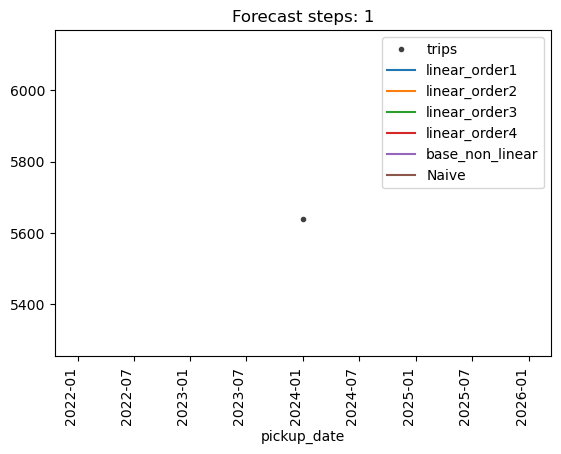

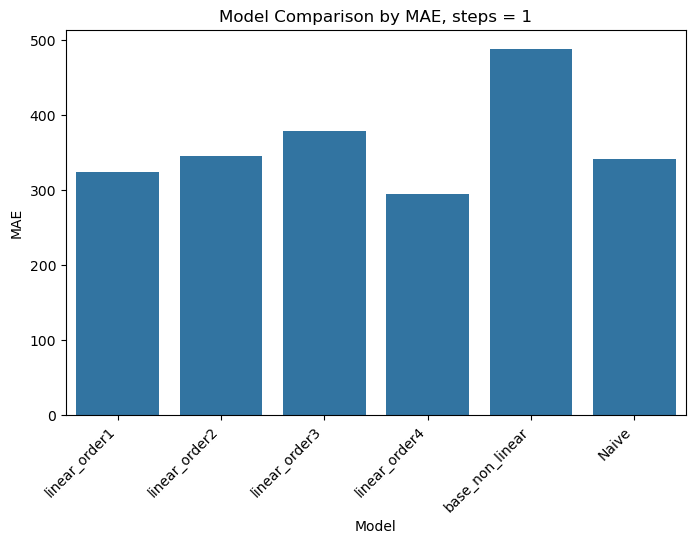

MAE Linear: 524.57 for step = 2, model = linear_order1
MAE Linear: 517.60 for step = 2, model = linear_order2
MAE Linear: 508.16 for step = 2, model = linear_order3
MAE Linear: 484.41 for step = 2, model = linear_order4
MAE Non Linear: 627.57 for step = 2, model = base_non_linear
Naive MAE: MAE = 664.00



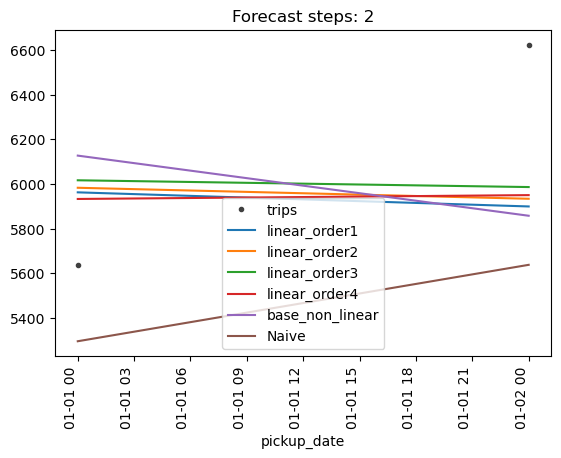

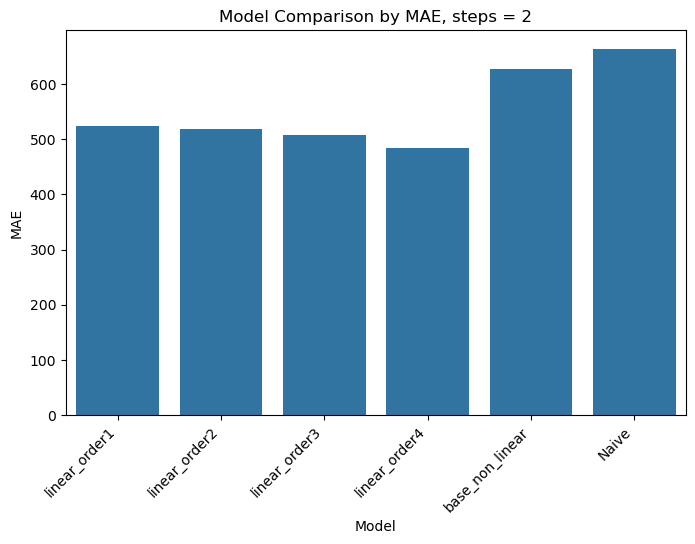

MAE Linear: 545.60 for step = 3, model = linear_order1
MAE Linear: 527.92 for step = 3, model = linear_order2
MAE Linear: 501.54 for step = 3, model = linear_order3
MAE Linear: 491.10 for step = 3, model = linear_order4
MAE Non Linear: 469.36 for step = 3, model = base_non_linear
Naive MAE: MAE = 604.33



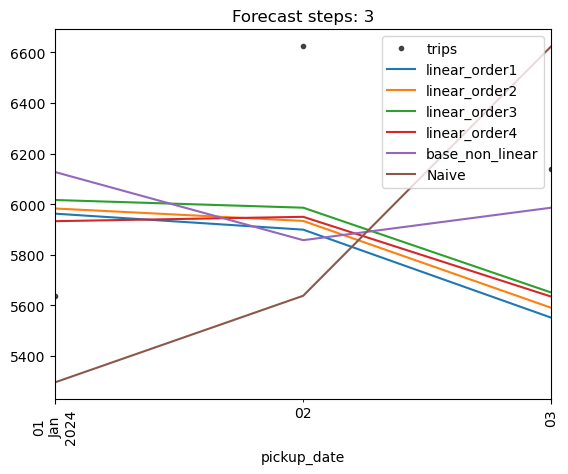

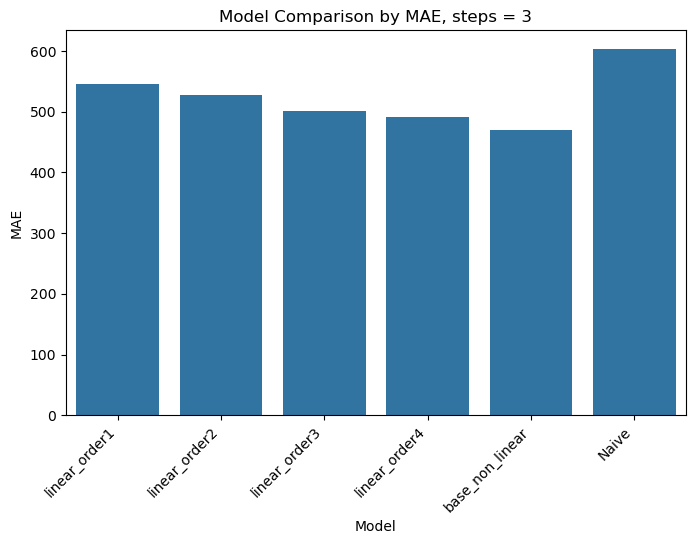

MAE Linear: 439.14 for step = 7, model = linear_order1
MAE Linear: 446.66 for step = 7, model = linear_order2
MAE Linear: 459.96 for step = 7, model = linear_order3
MAE Linear: 455.13 for step = 7, model = linear_order4
MAE Non Linear: 458.87 for step = 7, model = base_non_linear
Naive MAE: MAE = 592.71



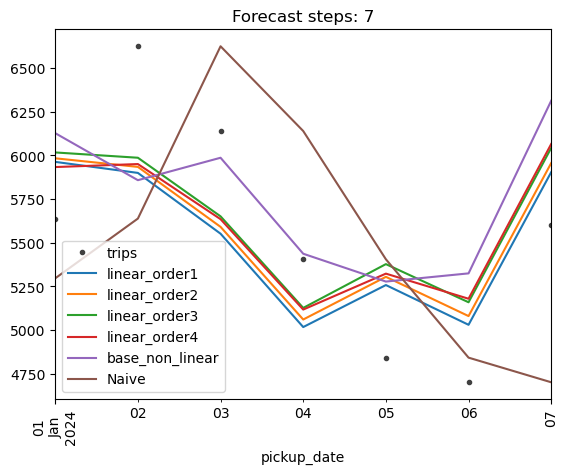

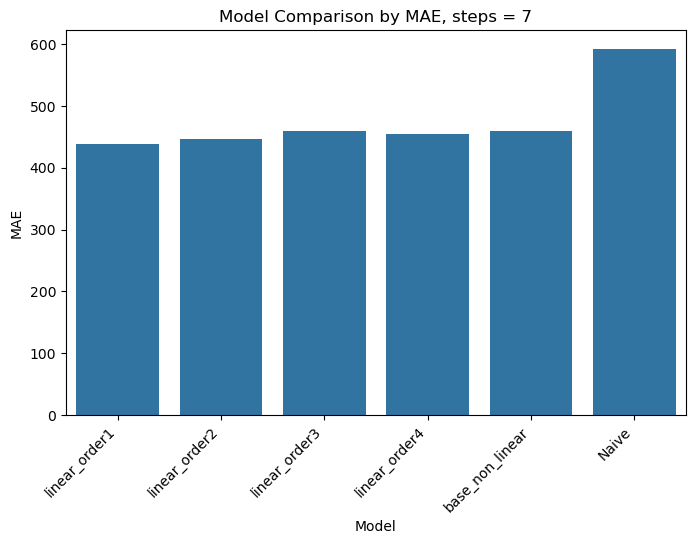

MAE Linear: 469.41 for step = 14, model = linear_order1
MAE Linear: 497.12 for step = 14, model = linear_order2
MAE Linear: 559.95 for step = 14, model = linear_order3
MAE Linear: 596.20 for step = 14, model = linear_order4
MAE Non Linear: 508.80 for step = 14, model = base_non_linear
Naive MAE: MAE = 537.71



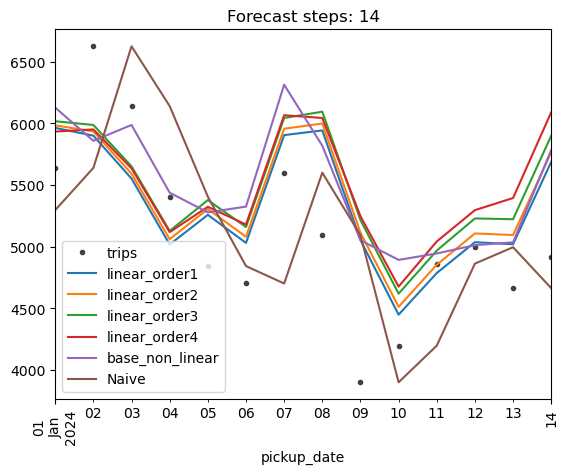

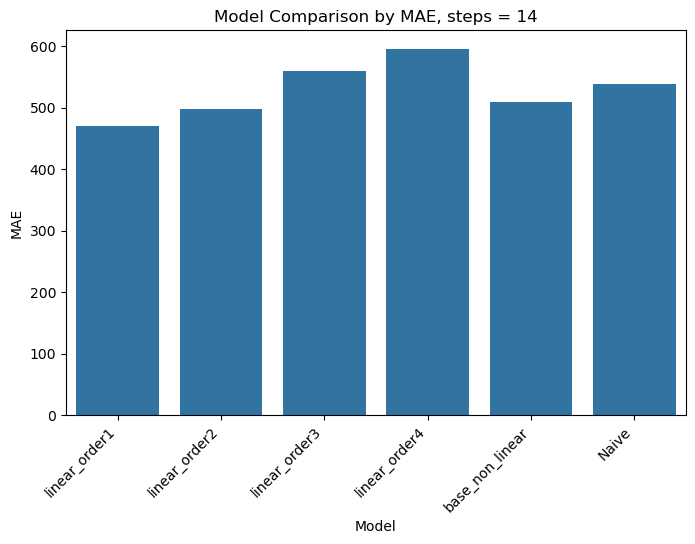

MAE Linear: 399.04 for step = 28, model = linear_order1
MAE Linear: 451.10 for step = 28, model = linear_order2
MAE Linear: 555.23 for step = 28, model = linear_order3
MAE Linear: 815.38 for step = 28, model = linear_order4
MAE Non Linear: 581.58 for step = 28, model = base_non_linear
Naive MAE: MAE = 543.11



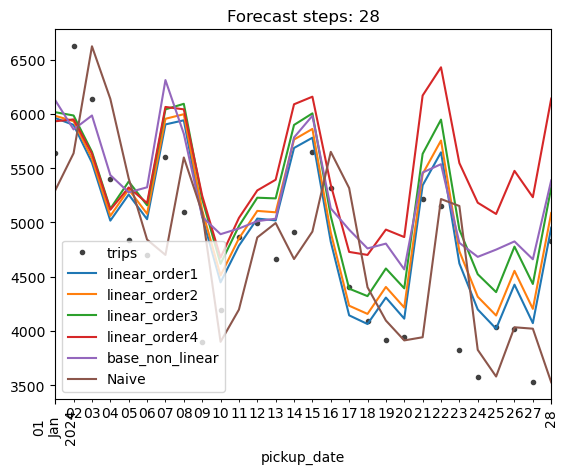

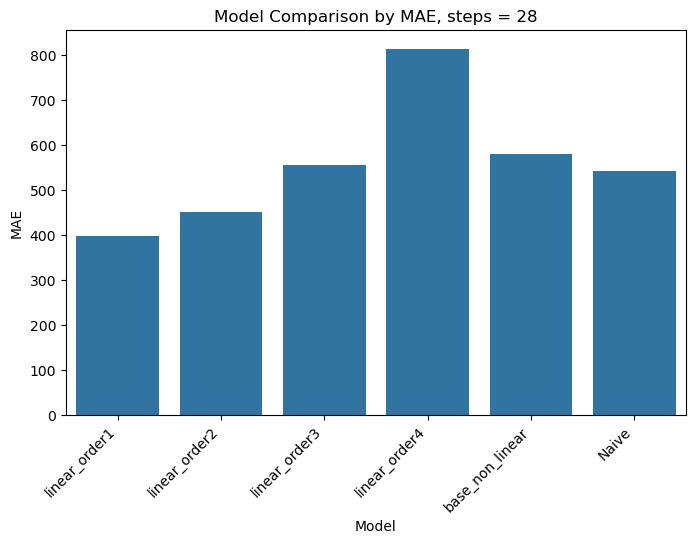

MAE Linear: 403.46 for step = 30, model = linear_order1
MAE Linear: 461.48 for step = 30, model = linear_order2
MAE Linear: 575.23 for step = 30, model = linear_order3
MAE Linear: 869.44 for step = 30, model = linear_order4
MAE Non Linear: 597.18 for step = 30, model = base_non_linear
Naive MAE: MAE = 545.37



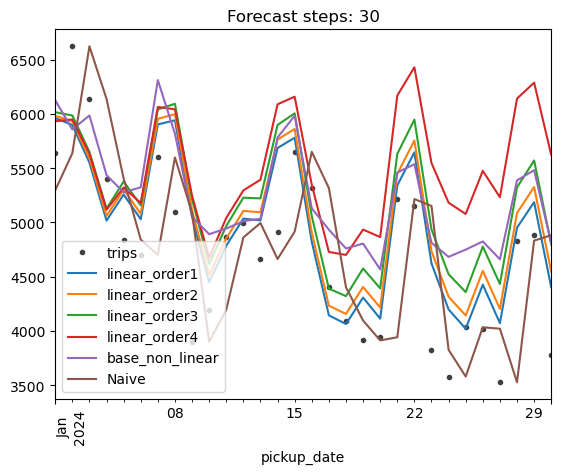

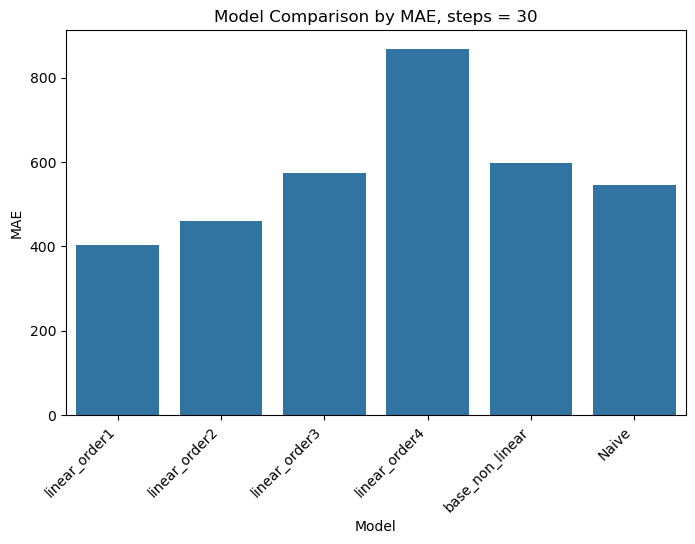

MAE Linear: 391.77 for step = 60, model = linear_order1
MAE Linear: 454.99 for step = 60, model = linear_order2
MAE Linear: 643.54 for step = 60, model = linear_order3
MAE Linear: 966.48 for step = 60, model = linear_order4
MAE Non Linear: 668.37 for step = 60, model = base_non_linear
Naive MAE: MAE = 541.90



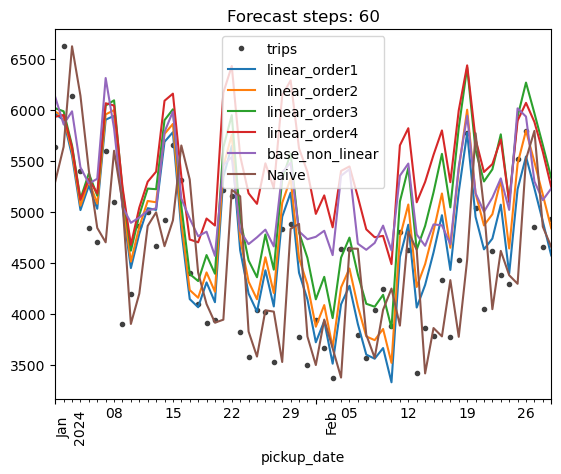

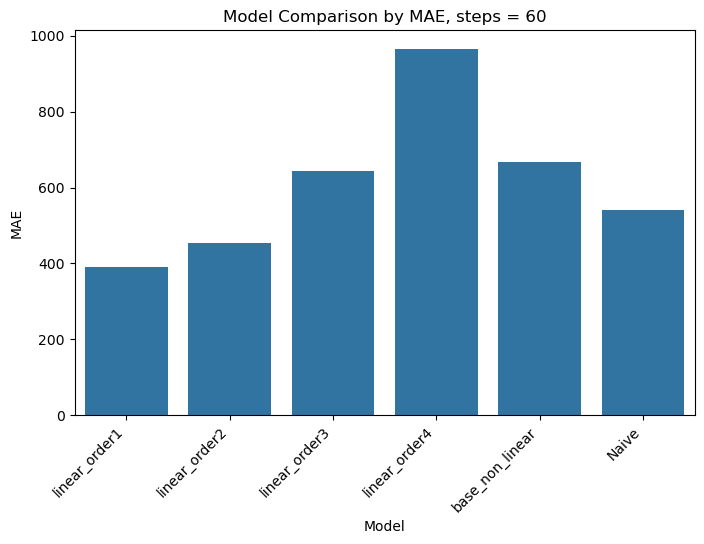

MAE Linear: 522.13 for step = 180, model = linear_order1
MAE Linear: 395.39 for step = 180, model = linear_order2
MAE Linear: 857.90 for step = 180, model = linear_order3
MAE Linear: 760.48 for step = 180, model = linear_order4
MAE Non Linear: 579.19 for step = 180, model = base_non_linear
Naive MAE: MAE = 583.99



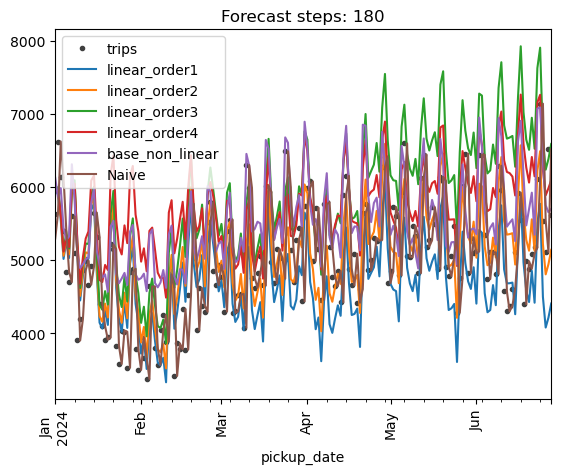

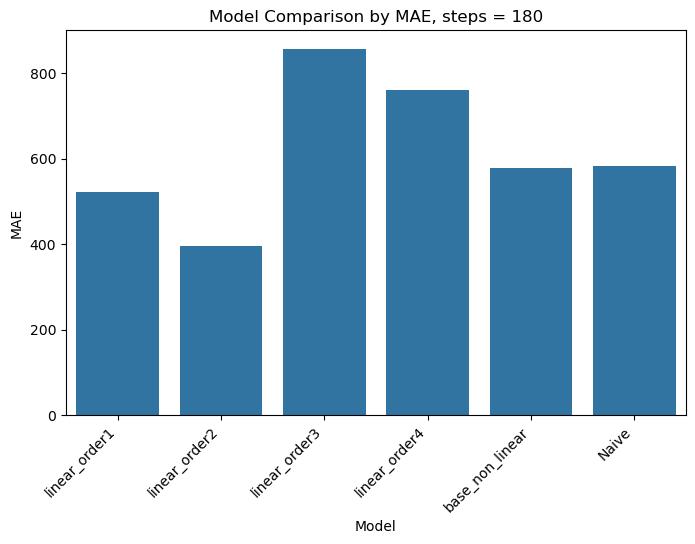

MAE Linear: 968.71 for step = 365, model = linear_order1
MAE Linear: 500.23 for step = 365, model = linear_order2
MAE Linear: 1434.15 for step = 365, model = linear_order3
MAE Linear: 1150.89 for step = 365, model = linear_order4
MAE Non Linear: 576.74 for step = 365, model = base_non_linear
Naive MAE: MAE = 613.42



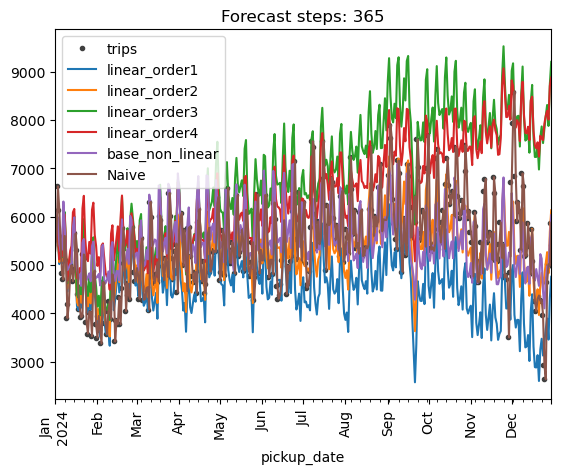

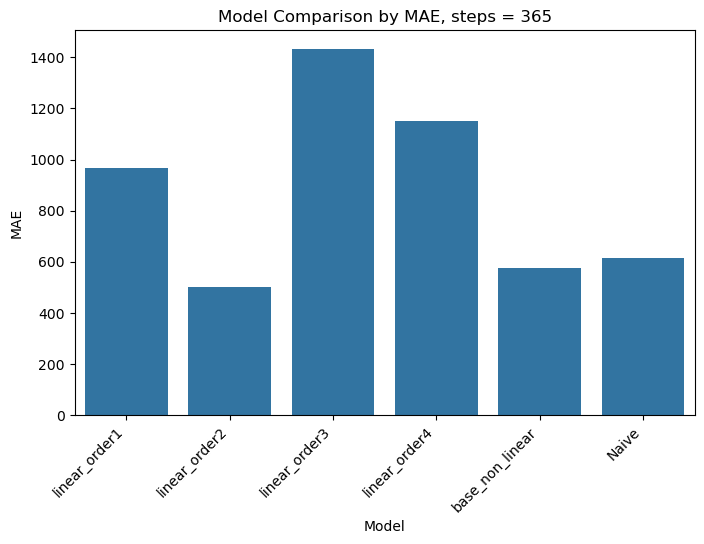

0

In [16]:
# Run forecasts
run_forecasts(steps, daily_lags, linear_models, non_linear_models, ts_daily_train, ts_daily_test)

In [12]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
        index = ts_daily_train.index,
        constant = False,   # Dummy feature for bias (y-intercept)
        order = 0,         # Polynomial trend (degree 1 = linear)
        seasonal = False,    # Don't use seasonal dummies
       # additional_terms = [fourier_yearly, fourier_weekly], # Add in the Fourier terms
        drop = True,       # Drop first column to avoid collinearity
)


In [13]:
dp

In [14]:
dp.in_sample()

""
2011-01-01
2011-01-02
2011-01-03
2011-01-04
2011-01-05
...
2023-12-27
2023-12-28
2023-12-29
2023-12-30
